In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time

## User input

In [3]:
sample_prefix = 'E:\\Ashlee\\PacBio\\20190207_D1-3_exchange_test\\PCA_blank\\m190207_164143_42131_c000469912559900001500000112312110_s1_p0'
color1 = 0
color2 = 2
leakage = np.zeros((4, 4))
background = [0, 0, 0, 0]
gamma = np.ones((4,))

In [16]:
def plot_one_trace(data, traceID, time_axis, foi):
#     plt.figure(figsize=(15, 2))
    trc = data[traceID]
    shape = data.shape
    if len(shape) == 2:
        plt.plot(time_axis[foi], trc[foi])
    else:
        n_channels = data.shape[1]
        for j in range(n_channels):
            plt.plot(time_axis[foi], trc[j][foi], color=colors[j], linewidth=0.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(traceID))

In [14]:
def plot_traces(n, data, indices, time_axis):
    plt.figure(figsize=(15, n*2))
#     if n % 2 == 1:
#         n = n-1
    for i in range(n):
        plt.subplot(n, 1, i+1)
        plot_one_trace(data, indices[i], time_axis, range(len(time_axis)))
#         
#         if len(data.shape) == 2:
#             plt.plot(time_axis, trc)
#         else:
#             for j in range(data.shape[1]):
#                 plt.plot(time_axis, trc[j], color=colors[j], linewidth=0.5)

#         plt.xlabel('Time (s)')
#         plt.ylabel('Intensity')
#         plt.title('Trace ' + str(indices[i]))
    plt.subplots_adjust(hspace=0.9)

In [5]:
def plot_traces_caller(n, toi, sorting_index, time_axis, foi, start, end, dyes, save=True):
    plot_traces(n, toi, sorting_index[start:end], time_axis[foi])
    filename = "%s_%d-%d_most_%s_anticorrelated.png" %(sample_prefix, start, end, dyes)
    if save:
        plt.savefig(filename, dpi=200)

In [6]:
def decode_and_plot(traces, traceID, decode_array, colors, foi, background, gamma, leakage, channels):
#     channels = range(4)
    trace = decode_array[traces[traceID]]
    plt.figure(figsize=(13,4))   
    
    for i in channels:
        trace[i] = trace[i] - background[i]
        print(i, np.mean(trace[i, -10:]))
        trace[i] = trace[i]*gamma[i]
        for j in channels:
            trace[i] = trace[i] - trace[j] * leakage[j, i]
    
    for j in channels:
        plt.plot(time_axis[foi], trace[j], color=colors[j], linewidth=0.4, alpha=0.9)

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    
    plt.figure(figsize=(13,4))
    don = trace[0]
    acc = trace[2]
    fret = acc/(don + acc)
    plt.plot(time_axis[foi], fret, linewidth=0.4)
    plt.ylim([-0.1, 1.1])
    print(fret)
    
    plt.xlabel('Time (s)')
    plt.ylabel('FRET efficiency')
    
    return fret


## Load data

In [4]:
start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

print("Time passed: " + str(time() - start))

Time passed: 0.20620012283325195


In [5]:
traces = raw_traces # skipping decode step to save memory

## Preprocessing

In [6]:
foi = range(3885, 3920) # frames of interest
n_frames = len(foi)
# threshold = int(n_frames*0.1) # reject traces with more than 10% frames saturated
traces = np.zeros((n_traces, 4, n_frames), dtype=np.uint8)
traces = raw_traces[:, :, foi]

In [7]:
avg_intens = np.mean(traces, axis=2)

In [23]:
start = time()
goodIDs = [] # indices of good traces
badIDs = [] # indices of bad traces
for i in range(n_traces):
    bad = False
    j = 0
    trace = traces[i, j]
    max_intens = np.max(trace)
    min_intens = np.min(trace)
    if max_intens == 255:
        bad = True
    elif min_intens == 0:
        bad = True
    if not bad:
        goodIDs.append(i)
    if bad:
        badIDs.append(i)

print("Time passed: " + str(time() - start) + " s")
print("Got rid of %d traces" %(len(badIDs)))

toi = traces[goodIDs]
toi.shape
n_traces = len(goodIDs)

avg_intens = np.mean(traces, axis=2)
avg_intens_good = np.mean(toi, axis=2)

Time passed: 1.541799783706665 s
Got rid of 374 traces


## Plot intensity distributions

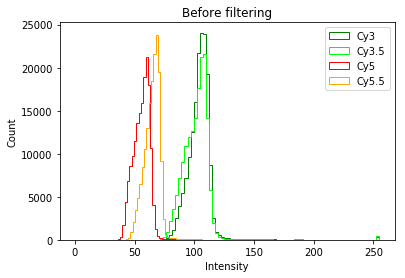

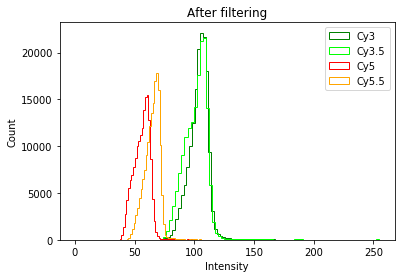

In [24]:
plt.figure()
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Before filtering")
plt.legend(lasers)

plt.figure()
for i in range(4):
    avg_intens_i = avg_intens_good.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("After filtering")
plt.legend(lasers)

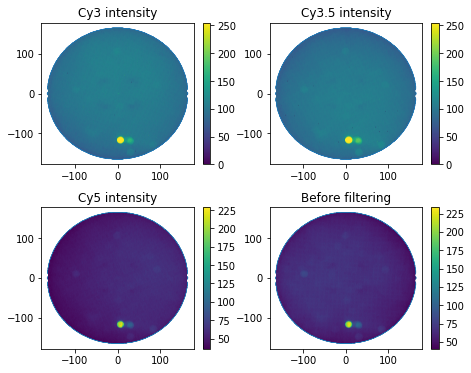

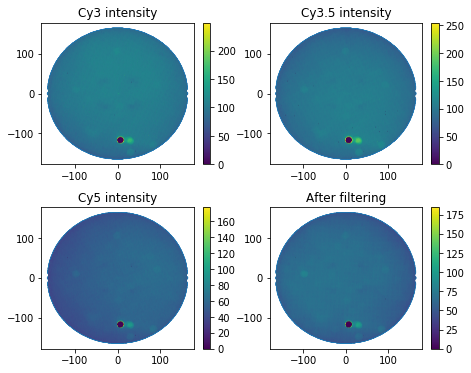

In [25]:
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.title("Before filtering")
plt.savefig(sample_prefix + '_grid.png')
plt.show()

avg_intens_good_plot = avg_intens
for i in badIDs:
    avg_intens_good_plot[i] = np.zeros((4,))
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_good_plot.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.title("After filtering")
plt.savefig(sample_prefix + '_grid_good_traces.png')
plt.show()

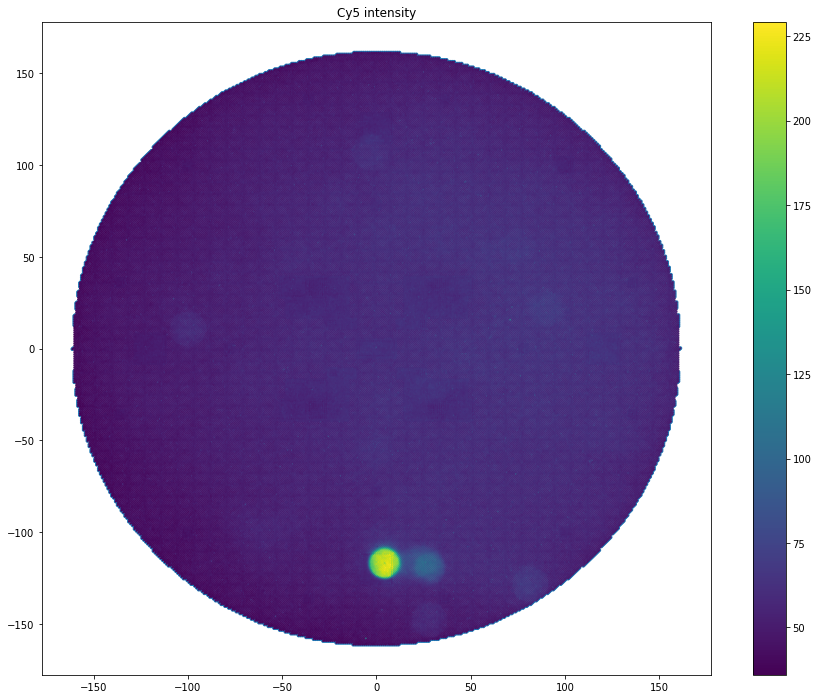

In [8]:
plt.figure(figsize=(15, 12))
i = 2
#     plt.subplot(2, 2, i+1)
plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
plt.title(lasers[i] + ' intensity')
plt.colorbar()
# plt.subplots_adjust(hspace=0.3)
# plt.title("Before filtering")
plt.savefig(sample_prefix + '_cy5_grid.png')
plt.show()

In [28]:
np.savetxt(sample_prefix + "_background.csv", avg_intens, delimiter=",")

In [ ]:
plt.figure()
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Before background subtract")
plt.legend(lasers)


## View a trace

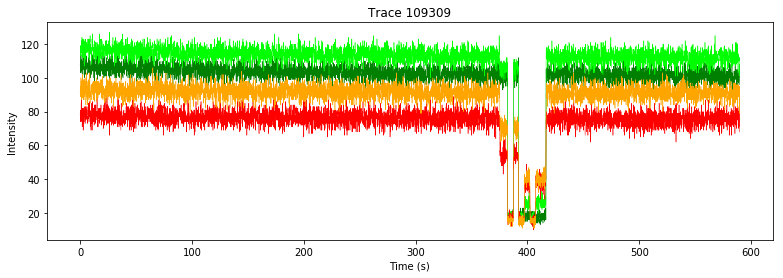

In [42]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
# plot_one_trace(raw_traces, traceID, time_axis, range(3980, 4020))
plot_one_trace(raw_traces, traceID, time_axis, range(0, 5900))

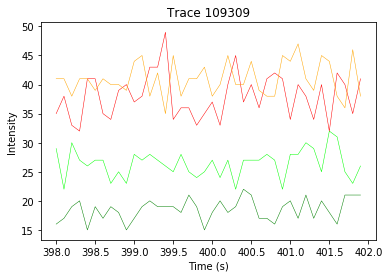

In [43]:
plot_one_trace(raw_traces, traceID, time_axis, range(3980, 4020))

Green only: range(3885, 3920)
Red only: range(3980, 4020)


## Sort by anticorrelation

In [ ]:
start = time()
# zero-center the traces
centered_traces = np.zeros((n_traces, 2, len(foi)), dtype=np.int32)
for i in range(n_traces):
    centered_traces[i, 0] = toi[i, color1] - avg_intens_good[i, color1]
    centered_traces[i, 1] = toi[i, color2] - avg_intens_good[i, color2]
    
print(time() - start)

Compare with normalized traces?

i = np.random.randint(0, n_traces)
ct = centered_traces[i]
plt.figure(figsize=(15,5))

for j in range(2):
    plt.plot(time_axis[foi], ct[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [ ]:
# Compute cross-correlation
corr_list = np.zeros(n_traces,dtype=np.int64)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][1]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

In [ ]:
plot_traces_caller(10, toi, sorting_index, time_axis, foi, 0, 100, "cy3cy5", save=False)